<h1 style="color:green">Important Libraries</h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

<h1 style="color:green">Reading CSV file</h1>

In [3]:
df = pd.read_csv('L://jupytar//owid-covid-data.csv')

In [4]:
s = 'India'

<h1 style="color:green">Cleaning and organising dataset</h1>

In [5]:
country = df[df['location']== s][['date' , 'new_cases']]

In [6]:
country.set_index('date' , inplace=True)
country.drop(['2021-01-08','2020-12-31','2021-01-02','2021-01-09'] , axis = 0 , inplace= True)

<h1 style="color:green">Manually rolling for <i><b>k</b></i> rows</h1> 

In [7]:
pred = []
std = []
k = 1
for i in range(len(country)-k):
    pred.append(np.mean(country.iloc[i:i+k]['new_cases']))
    std.append(np.std(country.iloc[i:i+k]['new_cases']))

In [8]:
country = country.iloc[k:]

In [9]:
country['Moving Average'] = pred
country['Standard Deviation'] = std

<AxesSubplot:xlabel='date'>

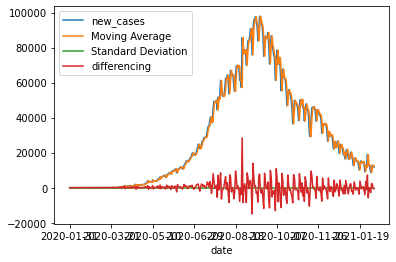

In [10]:
country['differencing'] = country['new_cases'] - country['Moving Average']
country.plot()

In [11]:
smooth = country.drop(['new_cases' , 'Moving Average' , 'Standard Deviation'] , axis = 1)
#smooth['differencing'] = np.sqrt(smooth['differencing'])

<AxesSubplot:xlabel='date'>

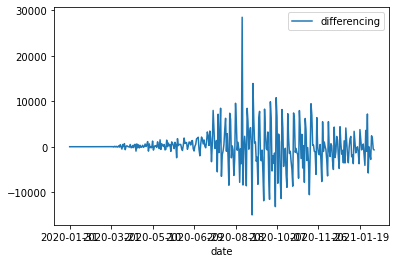

In [12]:
smooth.plot()

<h1 style="color:green">tranforming dataset to make it stationary</h1>

In [13]:
part = min(smooth['differencing'])
smooth['differencing'] = smooth['differencing'].apply(lambda x: x - part +1)
smooth['differencing'] = np.log(smooth['differencing'])

In [14]:
gfg = smooth['differencing'].describe()
#smooth['differencing'] = smooth['differencing'].apply(lambda x: x + part - 1)

<h1 style="color:green">eleminated all values not lying in Upper and lower limit (mean (+/-) 3* stddev)</h1>

In [15]:
ul = gfg.loc['mean'] + 3*gfg.loc['std']
ll = gfg.loc['mean'] - 3*gfg.loc['std']
smooth = smooth[smooth['differencing'] >= ll]
smooth = smooth[smooth['differencing'] <= ul]

<AxesSubplot:xlabel='date'>

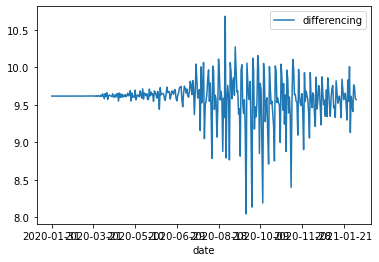

In [16]:
smooth.dropna(inplace=True)
#smooth = smooth[smooth['differencing'] > -14988]
smooth.plot()

In [17]:
smooth

,differencing
date,
2020-01-31,9.615339
2020-02-01,9.615405
2020-02-02,9.615472
2020-02-03,9.615405
2020-02-04,9.615339
...,...
2021-02-01,9.408617
2021-02-02,9.764111
2021-02-03,9.732343


<h1 style="color:green">Plotted ACF and PACF plots to get intuition of stationarity</h1>

In [18]:
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf

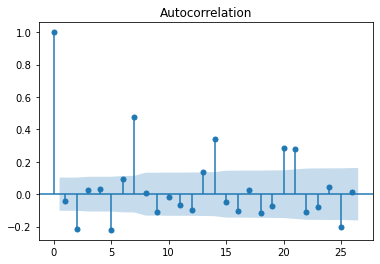

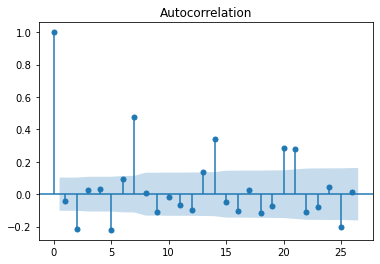

In [19]:
plot_acf(smooth)

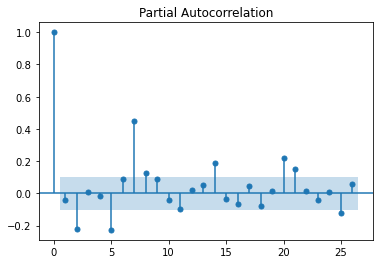

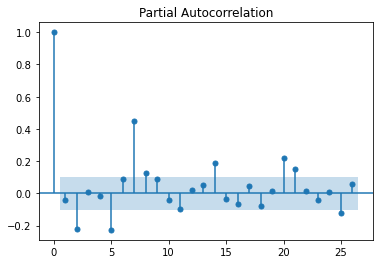

In [20]:
plot_pacf(smooth)

In [21]:
lg = smooth.shape[0]

<h1 style="color:green">Split training and testing dataset</h1>

In [22]:
breakpoint = (3*lg)//4
train = smooth.iloc[0:breakpoint]
test = country.iloc[breakpoint:]

In [23]:
country.iloc[0:breakpoint]

,new_cases,Moving Average,Standard Deviation,differencing
date,,,,
2020-01-31,0.0,1.0,0.0,-1.0
2020-02-01,0.0,0.0,0.0,0.0
2020-02-02,1.0,0.0,0.0,1.0
2020-02-03,1.0,1.0,0.0,0.0
2020-02-04,0.0,1.0,0.0,-1.0
...,...,...,...,...
2020-10-26,36470.0,45148.0,0.0,-8678.0
2020-10-27,43893.0,36470.0,0.0,7423.0
2020-10-28,49881.0,43893.0,0.0,5988.0


<h1 style="color:green">Execution of ARIMA Model</h1>

In [24]:
from statsmodels.tsa.arima_model import ARIMA

<h3 style="color:violet"><pre>p = 2
    q = 2
    i = 0
    </pre></h3>

In [25]:
model = ARIMA(train , order = (2 ,0 ,2))
model_fit = model.fit()
model_fit.aic

C:\Users\Arpit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


47.67324318413216

In [26]:
length = test.shape[0]

In [27]:
test.shape

(94, 4)

In [28]:
pre = model_fit.forecast(steps = length)[0]

<h1 style="color:green">Detransforming the values which were tranformed earlier to reduce non-stationarity</h1>

In [29]:
new_cases = []
init = 45213
for ele in pre:
    init += (part + np.exp(ele)  -1)
    new_cases.append(init)

In [30]:
pred = pd.DataFrame(new_cases , index=test.index)

In [31]:
final = pd.merge(pred , test , how = 'inner' , on = 'date')

In [32]:
final.rename(columns={0:'Predicted'} , inplace=True)
final

,Predicted,new_cases,Moving Average,Standard Deviation,differencing
date,,,,,
2020-10-31,45176.927420,46963.0,48268.0,0.0,-1305.0
2020-11-01,48632.408610,45231.0,46963.0,0.0,-1732.0
2020-11-02,46442.759692,38310.0,45231.0,0.0,-6921.0
2020-11-03,44337.180992,46253.0,38310.0,0.0,7943.0
2020-11-04,47676.723774,50210.0,46253.0,0.0,3957.0
...,...,...,...,...,...
2021-02-01,33653.914433,8635.0,11436.0,0.0,-2801.0
2021-02-02,32319.064405,11039.0,8635.0,0.0,2404.0
2021-02-03,32511.855054,12899.0,11039.0,0.0,1860.0


<h1 style="color:green">Plotted graph for original and predicted data</h1>

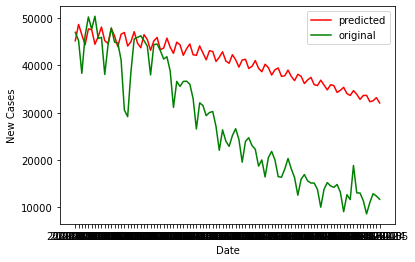

In [33]:
plt.plot(final.index, final['Predicted'] , color = 'red', label='predicted')
plt.plot(final.index, final['new_cases'] , color = 'green', label='original')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()